In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('fivethirtyeight')

%matplotlib inline

/Users/claus/miniconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
SEED = 42
np.random.seed(SEED)

In [3]:
pm.__version__

'3.7'

This notebook was inspired by this homework problem post by Richard McElreath: 
https://twitter.com/rlmcelreath/status/1177554702235525122

And influenced by Baze Petrushev's first take on a solution:
https://github.com/petrushev/bayesian-modeling/blob/andrews-spinner/andrews-spinner/andrews_spinner.ipynb


We set up the dataframe with the missing values as `np.nan`

In [18]:
data = pd.DataFrame([18, 19, 22, float(np.nan), float(np.nan), 19, 20, 22], columns=["frequency"])
k = len(data)
p = 1/k
k, p

(8, 0.125)

In [19]:
data

,frequency
0,18.0
1,19.0
2,22.0
3,NaN
4,NaN
5,19.0
6,20.0
7,22.0


In [31]:
missing_indeces = np.argwhere(np.isnan(data["frequency"])).flatten()
missing_indeces

array([3, 4])

Relying on PyMC3's handling of missing values, we pass the observed data _with_ missing values to a Poisson random variable. PyMC3 creates new random variables for each missing data point, which we can use downstream:

In [32]:
with pm.Model() as model_frequency:

    α = pm.Exponential("α", 1)
    β = pm.Exponential("β", .1)
    λ = pm.Gamma("λ", α, β)
    spins = pm.Poisson("spins", mu=λ, observed=data["frequency"])
    
    # We create an imputed dataset by filling in the missing variables with our new random variables
    data_obs_imputed = list(data["frequency"])
    
    for i, m in enumerate(missing_indeces):
        data_obs_imputed[m] = spins[i]

    data_obs_imputed = pm.Deterministic("data_obs_imputed", pm.math.stack(data_obs_imputed))

    # We use the new total number of spins (including the posteriors of the missing variables)
    total_spins_imputed = pm.Deterministic("total_spins_imputed", pm.math.sum(data_obs_imputed))
    
    a = np.ones(k)/k
    theta = pm.Dirichlet("theta", a=a)
    
    successes = pm.Multinomial("successes", 
                             n=total_spins_imputed, 
                             p=theta, 
                             observed=data_obs_imputed)

/Users/claus/miniconda3/lib/python3.7/site-packages/pymc3/model.py:1331: UserWarning: Data in spins contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)


In [33]:
model_frequency

In [34]:
with model_frequency:
    trace_frequency = pm.sample(20000, tune=3000, chains=3, random_seed=SEED)

Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>NUTS: [theta, λ, β, α]
>Metropolis: [spins_missing]
Sampling 3 chains: 100%|██████████| 69000/69000 [00:44<00:00, 1543.42draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


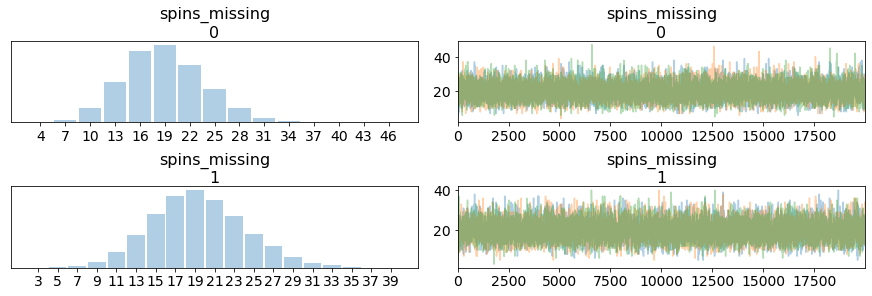

In [35]:
with model_frequency:
    pm.traceplot(trace_frequency, var_names=["spins_missing"], divergences=False, combined=True);

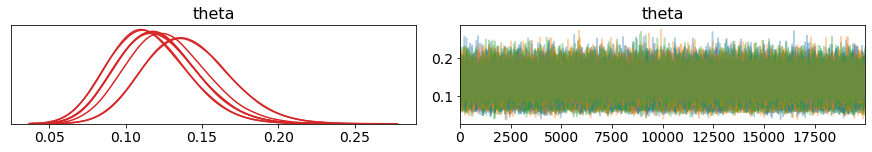

In [36]:
with model_frequency:
    pm.traceplot(trace_frequency, var_names=["theta"], divergences=False, compact=True, combined=True);

In [37]:
data["probability"] = trace_frequency["theta"].mean(axis=0)
data

,frequency,probability
0,18.0,0.114847
1,19.0,0.120967
2,22.0,0.140020
3,NaN,0.114844
4,NaN,0.121021
5,19.0,0.120958
6,20.0,0.127333
7,22.0,0.140010


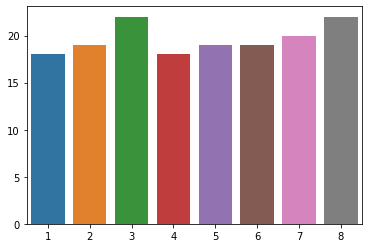

In [38]:
sns.barplot(x=np.arange(1, k+1), y=np.median(trace_frequency["data_obs_imputed"], axis=0));

/Users/claus/miniconda3/lib/python3.7/site-packages/arviz/plots/forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/Users/claus/miniconda3/lib/python3.7/site-packages/arviz/plots/forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


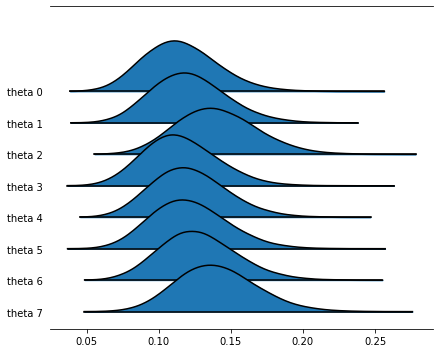

In [39]:
az.plot_forest(trace_frequency, var_names=["theta"], kind="ridgeplot", combined=True);

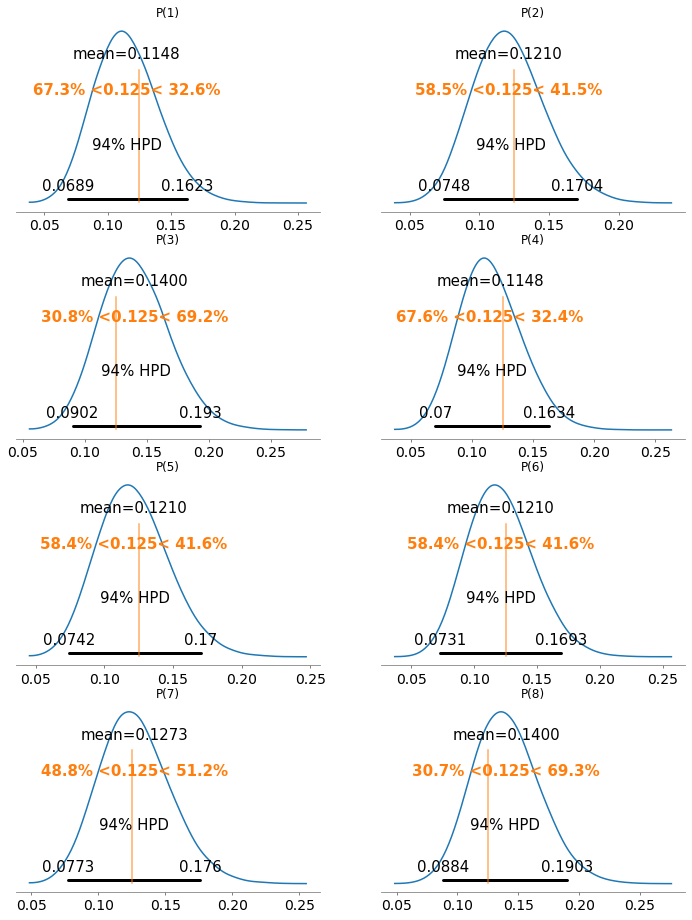

In [40]:
_, axes = plt.subplots(4, 2, figsize=(6*2, 4*4))
axes = axes.flatten()
for i in range(k):
    pm.plot_posterior(trace_frequency["theta"][:, i], ax=axes[i], round_to=4, ref_val=1/k)
    axes[i].set_title(f"P({i+1})")

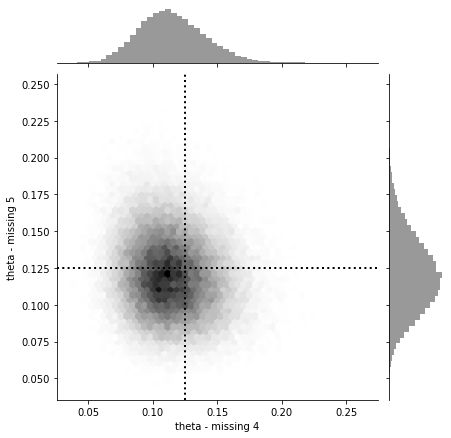

In [41]:
g = sns.jointplot(trace_frequency["theta"][:, 3], 
              trace_frequency["theta"][:, 4],
              kind="hex", 
              color="k")
g.ax_joint.axhline(1/k, linestyle="dotted", linewidth=2, color="k")
g.ax_joint.axvline(1/k, linestyle="dotted", linewidth=2, color="k")
g.set_axis_labels("theta - missing 4", "theta - missing 5");